In [10]:
import os
import cv2
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew

In [11]:
# Set the path to your labeled dataset folders
malicious_dir = 'QR codes\Malicious\malicious'
non_malicious_dir = r'QR codes\Benign\benign'

# List to store the labels ('malicious' or 'non-malicious') and features
labels = []
features = []

# Function to extract statistical features from an image
def extract_features(image):
    features = []
    features.append(np.mean(image))
    features.append(np.std(image))
    features.append(skew(image.flatten()))
    return features

# Load malicious images and extract features
for filename in os.listdir(malicious_dir):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        labels.append('malicious')
        img = cv2.imread(os.path.join(malicious_dir, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        img_features = extract_features(img)
        features.append(img_features)

# Load non-malicious images and extract features
for filename in os.listdir(non_malicious_dir):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        labels.append('non-malicious')
        img = cv2.imread(os.path.join(non_malicious_dir, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        img_features = extract_features(img)
        features.append(img_features)

# Convert labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Convert data to Light GBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for Light GBM
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [17]:
# Create and train the LightGBM model
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1622, number of negative: 1578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506875 -> initscore=0.027502
[LightGBM] [Info] Start training from score 0.027502


LGBMClassifier()

In [39]:
model.booster_.save_model('mode.txt')

In [ ]:
# load from model:
GBM_model = lgb.Booster(model_file='mode.txt')

In [1]:
import joblib
# save model
# joblib.dump(model, 'lgb.pkl')
# load model
gbm_pickle = joblib.load('lgb.pkl')

In [18]:
accuracy = model.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.66125


In [19]:
def extract_features_gbm(image):
    features = []
    features.append(np.mean(image))
    features.append(np.std(image))
    features.append(skew(image.flatten()))
    return features
 
def lightGBM(new_qr_code_path):
    new_qr_code_path = 'path'
    img = cv2.imread(new_qr_code_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    new_features = extract_features_gbm(img)
    prediction = model.predict(np.array([new_features]))
    predicted_class = 1 if prediction[0] > 0.5 else 0
    # Print the prediction
    if predicted_class == 0:
        return "NON MALICIOUS"
    else:
        return "MALICIOUS"

In [21]:
predicted_class = 1 if prediction[0] > 0.5 else 0

# Print the prediction
if predicted_class == 0:
    print("Predicted class: non-malicious")
else:
    print("Predicted class: malicious")

Predicted class: malicious


In [29]:
y_pred=model.predict(X_test)

In [32]:
from sklearn.metrics import confusion_matrix,f1_score,precision_recall_curve,accuracy_score,roc_auc_score
confusion_matrix(y_test,y_pred)


array([[303, 119],
       [152, 226]], dtype=int64)

In [33]:
accuracy_score(y_test,y_pred)


0.66125

In [34]:
f1_score(y_test,y_pred)


0.6251728907330567

In [37]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)

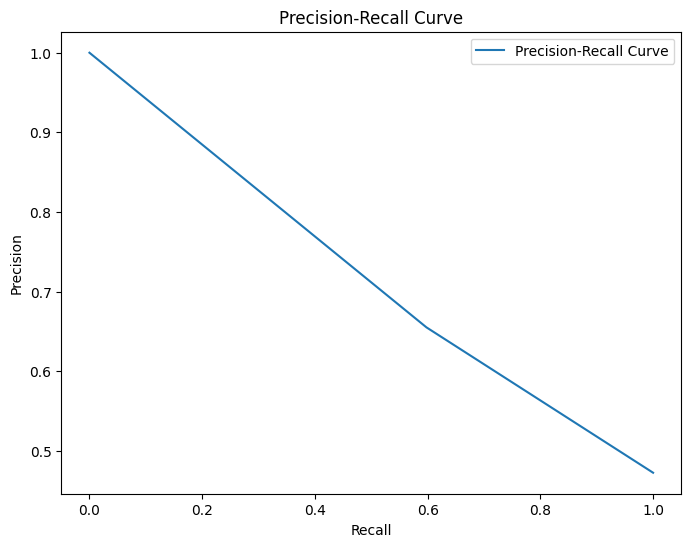

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()